<a href="https://colab.research.google.com/github/plaban1981/Huggingface_transformers_course/blob/main/Fine_tuning_a_pretrained_HuggingFace_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Transformers

In [2]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.5 MB/s 
     |████████████████████████████████| 3.3 MB 51.5 MB/s 
     |████████████████████████████████| 636 kB 60.3 MB/s 
     |████████████████████████████████| 895 kB 64.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


* How to prepare a large dataset from the Hub
* How to use the high-level Trainer API to fine-tune a model
* How to use a custom training loop
* How to leverage the 🤗 Accelerate library to easily run that custom training loop on an

## Processing the data

In [3]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
print(batch)
# This is new
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2023,  2607,  2003,  6429,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


* To get better results, you will need to prepare a bigger dataset.
* the MRPC (Microsoft Research Paraphrase Corpus) dataset
* The dataset consists of 5,801 pairs of sentences, with a label indicating if they are paraphrases or not (i.e., if both sentences mean the same thing).

## Loading a dataset from the Hub

* The Hub doesn’t just contain models; it also has multiple datasets in lots of different languages. 


* You can browse the datasets here, and we recommend you try to load and process a new dataset once you have gone through this section (see the general documentation here).https://huggingface.co/docs/datasets/loading_datasets.html#from-the-huggingface-hub

* The 🤗 Datasets library provides a very simple command to download and cache a dataset on the Hub

In [4]:
! pip install datasets

     |████████████████████████████████| 264 kB 7.8 MB/s 
     |████████████████████████████████| 243 kB 13.9 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
     |████████████████████████████████| 118 kB 14.3 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## Loading a dataset from the Hub

In [5]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")#Microsoft Research Paraphrase Corpus
raw_datasets

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

we get a DatasetDict object which contains the training set, the validation set, and the test set. Each of those contains several columns (sentence1, sentence2, label, and idx) and a variable number of rows, which are the number of elements in each set (so, there are 3,668 pairs of sentences in the training set, 408 in the validation set, and 1,725 in the test set).

* We can access each pair of sentences in our raw_datasets object by indexing, like with a dictionary:

In [6]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'idx': 0,
 'label': 1,
 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'}

* The labels are already integers, so we won’t have to do any preprocessing there
* To know which integer corresponds to which label, we can inspect the features of our raw_train_dataset. 

In [7]:
raw_train_dataset.features

{'idx': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_file=None, id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None)}

## Observation
* label is of type ClassLabel
* 0 corresponds to not_equivalent, 
* 1 corresponds to equivalent

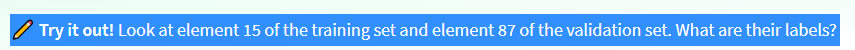

In [8]:
raw_train_dataset[15]

{'idx': 16,
 'label': 0,
 'sentence1': 'Rudder was most recently senior vice president for the Developer & Platform Evangelism Business .',
 'sentence2': 'Senior Vice President Eric Rudder , formerly head of the Developer and Platform Evangelism unit , will lead the new entity .'}

In [9]:
raw_train_dataset[87]

{'idx': 100,
 'label': 1,
 'sentence1': 'Tuition at four-year private colleges averaged $ 19,710 this year , up 6 percent from 2002 .',
 'sentence2': 'For the current academic year , tuition at public colleges averaged $ 4,694 , up almost $ 600 from the year before .'}

## To preprocess the dataset, we need to convert the text to numbers for the model to make sense . This can be acheived through Tokenization

In [10]:
type(raw_train_dataset[0])

dict

In [11]:
raw_train_dataset[0]

{'idx': 0,
 'label': 1,
 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'}

In [12]:
from transformers import AutoTokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
inputs = tokenizer(raw_train_dataset[0]['sentence1'],raw_train_dataset[0]['sentence2'])

In [13]:
inputs

{'input_ids': [101, 2572, 3217, 5831, 5496, 2010, 2567, 1010, 3183, 2002, 2170, 1000, 1996, 7409, 1000, 1010, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 7727, 2000, 2032, 2004, 2069, 1000, 1996, 7409, 1000, 1010, 2572, 3217, 5831, 5496, 2010, 2567, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## inputids / encoding

In [14]:
print(inputs['input_ids'])

[101, 2572, 3217, 5831, 5496, 2010, 2567, 1010, 3183, 2002, 2170, 1000, 1996, 7409, 1000, 1010, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 7727, 2000, 2032, 2004, 2069, 1000, 1996, 7409, 1000, 1010, 2572, 3217, 5831, 5496, 2010, 2567, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102]


## token_type_ids :  tells the model which part of the input is the first sentence and which is the second sentence.

In [15]:
print(inputs['token_type_ids'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## attention_mask : tells to ignore the values encoded for padding(0)

In [16]:
print(inputs['attention_mask'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Decoding input_ids back to words:

In [17]:
print(tokenizer.convert_ids_to_tokens(inputs['input_ids']))

['[CLS]', 'am', '##ro', '##zi', 'accused', 'his', 'brother', ',', 'whom', 'he', 'called', '"', 'the', 'witness', '"', ',', 'of', 'deliberately', 'di', '##stor', '##ting', 'his', 'evidence', '.', '[SEP]', 'referring', 'to', 'him', 'as', 'only', '"', 'the', 'witness', '"', ',', 'am', '##ro', '##zi', 'accused', 'his', 'brother', 'of', 'deliberately', 'di', '##stor', '##ting', 'his', 'evidence', '.', '[SEP]']


* [CLS] sentence1 [SEP] all have a token type ID of 0, while the other parts, corresponding to sentence2 [SEP], all have a token type ID of 1.

* If we select a different checkpoint, not necessarily we will have the token_type_ids in your tokenized inputs (for instance, they’re not returned if you use a DistilBERT model).

* BERT is pretrained with token type IDs, and on top of the masked language modeling objective , it has an additional objective called next sentence prediction. 

* The goal with this task is to model the relationship between pairs of sentences.

* With next sentence prediction, the model is provided pairs of sentences (with randomly masked tokens) and asked to predict whether the second sentence follows the first. 
* To make the task non-trivial, half of the time the sentences follow each other in the original document they were extracted from, and the other half of the time the two sentences come from two different documents.

* In general,we don’t need to worry about whether or not there are token_type_ids in our  tokenized inputs: as long as we use the same checkpoint for the tokenizer and the model, everything will be fine as the tokenizer knows what to provide to its model.

In [18]:
tokenized_sentences = tokenizer(raw_train_dataset[0]['sentence1'],raw_train_dataset[0]['sentence2'],padding=True,truncation=True)

In [19]:
print(tokenized_sentences)

{'input_ids': [101, 2572, 3217, 5831, 5496, 2010, 2567, 1010, 3183, 2002, 2170, 1000, 1996, 7409, 1000, 1010, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 7727, 2000, 2032, 2004, 2069, 1000, 1996, 7409, 1000, 1010, 2572, 3217, 5831, 5496, 2010, 2567, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


* The above method has the disadvantage of returning a dictionary (with our keys, input_ids, attention_mask, and token_type_ids, and values that are lists of lists). 

## Define a map function 
* To keep the data as a dataset, we will use the Dataset.map method. This also allows us some extra flexibility, if we need more preprocessing done than just tokenization. The map method works by applying a function on each element of the dataset

* This function takes a dictionary and returns a new dictionary with the keys input_ids, attention_mask, and token_type_ids. 

* We have dropped  the padding argument out in our tokenization function for now. This is because padding all the samples to the maximum length is not efficient.
* It is  better to pad the samples when we are building a batch, as then we only need to pad to the maximum length in that batch, and not the maximum length in the entire dataset. 
* This can save a lot of time and processing power when the inputs have very variable lengths!

In [20]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [44]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

#### tokenize_function returns a dictionary with the keys input_ids, attention_mask, and token_type_ids, 

In [22]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence1', 'sentence2', 'token_type_ids'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence1', 'sentence2', 'token_type_ids'],
        num_rows: 408
    })
    test: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence1', 'sentence2', 'token_type_ids'],
        num_rows: 1725
    })
})

In [23]:
print(tokenized_datasets['train']['input_ids'])

[[101, 2572, 3217, 5831, 5496, 2010, 2567, 1010, 3183, 2002, 2170, 1000, 1996, 7409, 1000, 1010, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 7727, 2000, 2032, 2004, 2069, 1000, 1996, 7409, 1000, 1010, 2572, 3217, 5831, 5496, 2010, 2567, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102], [101, 9805, 3540, 11514, 2050, 3079, 11282, 2243, 1005, 1055, 2077, 4855, 1996, 4677, 2000, 3647, 4576, 1999, 2687, 2005, 1002, 1016, 1012, 1019, 4551, 1012, 102, 9805, 3540, 11514, 2050, 4149, 11282, 2243, 1005, 1055, 1999, 2786, 2005, 1002, 6353, 2509, 2454, 1998, 2853, 2009, 2000, 3647, 4576, 2005, 1002, 1015, 1012, 1022, 4551, 1999, 2687, 1012, 102], [101, 2027, 2018, 2405, 2019, 15147, 2006, 1996, 4274, 2006, 2238, 2184, 1010, 5378, 1996, 6636, 2005, 5096, 1010, 2002, 2794, 1012, 102, 2006, 2238, 2184, 1010, 1996, 2911, 1005, 1055, 5608, 2018, 2405, 2019, 15147, 2006, 1996, 4274, 1010, 5378, 1996, 14792, 2005, 5096, 1012, 102], [101, 2105, 6021, 19481, 13938, 2102, 1010, 21628, 6661, 

In [24]:
print(tokenized_datasets['train']['attention_mask'])

In [25]:
print(tokenized_datasets['train']['token_type_ids'])

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

* We can even use multiprocessing when applying your preprocessing function with Dataset.map by passing along a num_proc argument. 

* In the above we have not used multiprocessing parameter because the 🤗 Tokenizers library already uses multiple threads to tokenize our samples faster.

* But if we are not using a fast tokenizer backed by this library, this could speed up our preprocessing.

## Dynamic padding

Dynamic padding means the samples in a batch should all be padded to (a length of sentences having the maximun numbrer of characters,) the maximum length inside the batch.

* The 🤗 Transformers library provides us with a function via **DataCollatorWithPadding** which will apply the correct amount of padding to the items of the dataset we want to batch together. 

* It takes a tokenizer when you instantiate it (to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs) and will do everything you need

In [26]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

* Grab a few samples from our training set that we would like to batch together. 
* Here, we remove the columns idx, sentence1, and sentence2 as they won’t be needed and contain strings (and we can’t create tensors with strings) and have a look at the lengths of each entry in the batch:

In [27]:
print(tokenized_datasets["train"][:8])

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## Removing the columns idx, sentence1, and sentence2  as they will not be required

In [45]:
samples = tokenized_datasets["train"][:8]
samples = {
    k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]
}
[len(x) for x in samples["input_ids"]]

[10, 11, 15, 10, 22, 13, 29, 6]

* Here we get samples of varying length, from 32 to 67. 
* Dynamic padding means the samples in this batch should all be padded to a length of 67, the maximum length inside the batch.

In [29]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([8, 67]),
 'input_ids': torch.Size([8, 67]),
 'labels': torch.Size([8]),
 'token_type_ids': torch.Size([8, 67])}

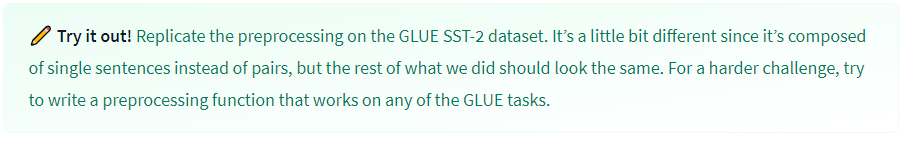

In [46]:
raw_datasets = load_dataset("glue", "sst2")
raw_datasets

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [31]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'idx': 0,
 'label': 0,
 'sentence': 'hide new secretions from the parental units '}

In [32]:
raw_train_dataset[0]['sentence']

'hide new secretions from the parental units '

In [33]:
def tokenize_function1(example):
    return tokenizer(example["sentence"], truncation=True)

In [34]:
tokenized_datasets = raw_datasets.map(tokenize_function1, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence', 'token_type_ids'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence', 'token_type_ids'],
        num_rows: 872
    })
    test: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence', 'token_type_ids'],
        num_rows: 1821
    })
})

In [35]:
tokenized_datasets["train"][0:]

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1],
  [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   

In [36]:
samples = tokenized_datasets["train"][0:10]
samples = {
    k: v for k, v in samples.items() if k not in ["idx", "sentence"]
}
[len(x) for x in samples["input_ids"]]

[10, 11, 15, 10, 22, 13, 29, 6, 13, 16]

*  the maximum length inside the batch is 29.
* hence dynamic padding using DataCollatorWithPadding will pad the encoders to the maximum length inside the batch which is 29

In [37]:
print(samples)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102], [101, 3397, 2053, 15966, 1010, 2069, 4450, 2098, 18201, 2015, 102], [101, 2008, 7459, 2049, 3494, 1998, 10639, 2015, 2242, 2738, 3376, 2055, 2529, 3267, 102], [101, 3464, 12580, 8510, 2000, 3961, 1996, 2168, 2802, 102], [101, 2006, 1996, 5409, 7195, 1011, 1997, 1011, 1996, 1011, 11265, 17811, 18856, 17322, 2015, 1996, 16587, 2071, 2852, 24225, 2039, 102], [101, 2008, 1005, 1055, 2521, 2205, 13800, 2000, 7857, 2107, 23105, 3949, 102], [101, 16691

## Dynamic padding

In [38]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [39]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([10, 29]),
 'input_ids': torch.Size([10, 29]),
 'labels': torch.Size([10]),
 'token_type_ids': torch.Size([10, 29])}

* So here the maximum length inside the batch is 29

In [40]:
batch['input_ids'].shape

torch.Size([10, 29])

* the encoders or input_ids have been padded with length 29

## Fine-tuning a model with the Trainer API

* 🤗 Transformers provides a Trainer class to help you fine-tune any of the pretrained models it provides on your dataset.

In [41]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

## Training

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-df978b9698245ee9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-c4179dfff26b5669.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

* The first step before we can define our Trainer is to define a TrainingArguments class that will contain all the hyperparameters the Trainer will use for training and evaluation

* The only argument we have to provide is a directory where the trained model will be saved, as well as the checkpoints along the way. 

In [2]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [3]:
print(training_args)

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
greater_is_better=None,
group_by_length=False,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_at_end=False,
local_rank=-1,
log_level=-1,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=test-trainer/runs/Jul31_18-10-38_d08bf97b31e9,
logging_first_step=False,
logging_steps=500,
logging_strategy=IntervalStrategy.STEPS,
lr_scheduler_type=SchedulerType.LINEAR,
max_grad_norm=1.0,
max_steps=-1,
metric_for_b

## BERT AutoModelForSequenceClassification

In [5]:
checkpoint

'bert-base-uncased'

In [6]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

* Here we get a warning after instantiating this pretrained model. 
* This is because BERT has not been pretrained on classifying pairs of sentences, so the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead. 
* The warnings indicates that some weights were not used (the ones corresponding to the dropped pretraining head) and that some others were randomly initialized (the ones for the new head). 
* The warning concludes by encouraging us to train the model, in order to have better weights initializations.

## Define Trainer
the objects constructed up to now — 

* the model, 
* the training_args, 
* the training and 
* validation datasets, 
* data_collator, and 
* tokenizer

In [7]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

* To fine-tune the model on our dataset, we just have to call the train method of our Trainer:

In [8]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377


Step,Training Loss
500,0.492800
1000,0.259700


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1377, training_loss=0.3047319438549255, metrics={'train_runtime': 134.4252, 'train_samples_per_second': 81.86, 'train_steps_per_second': 10.244, 'total_flos': 405470580750720.0, 'train_loss': 0.3047319438549255, 'epoch': 3.0})

This will start the fine-tuning (which should take a couple of minutes on a GPU) and report the training loss every 500 steps. 

It won’t, however, tell you how well (or badly) your model is performing. This is because:

* We didn’t tell the Trainer to evaluate during training by setting evaluation_strategy to either "steps" (evaluate every eval_steps) or "epoch" (evaluate at the end of each epoch).
* We didn’t provide the Trainer with a compute_metrics function to calculate a metric during said evaluation (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).

## Evaluation

In [9]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8


(408, 2) (408,)


* To transform them into predictions that we can compare to our labels, we need to take the index with the maximum value on the second axis:

## The output of the predict method is another named tuple with three fields: 

* predictions, 
* label_ids, and 
* metrics.

In [10]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)
print(preds)

[1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0
 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0
 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0
 0]


## Define compute_metric function, here we will rely on the metrics from the 🤗 Datasets library.

In [11]:
from datasets import load_metric

metric = load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

{'accuracy': 0.8529411764705882, 'f1': 0.896551724137931}

* Here, we can see our model has an accuracy of 85.78% on the validation set and an F1 score of 89.97. Those are the two metrics used to evaluate results on the MRPC dataset for the GLUE benchmark

In [19]:
def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Define a new Trainer with this compute_metrics function:

In [20]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad

In [14]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.390982,0.828431,0.874101
2,0.503300,0.497703,0.857843,0.902027
3,0.306000,0.565746,0.860294,0.900870


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoin

TrainOutput(global_step=1377, training_loss=0.3379397755874268, metrics={'train_runtime': 141.4396, 'train_samples_per_second': 77.8, 'train_steps_per_second': 9.736, 'total_flos': 405470580750720.0, 'train_loss': 0.3379397755874268, 'epoch': 3.0})

* The Trainer will work out of the box on multiple GPUs or TPUs and provides lots of options, like mixed-precision training (use fp16 = True in our training arguments).

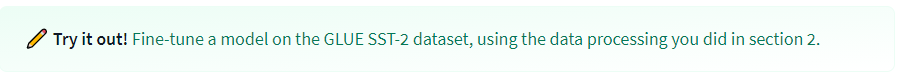

## Prepare Tokens

In [15]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "sst2")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
from transformers import TrainingArguments
training_args = TrainingArguments("test-trainer-sst2")
#


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [18]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/tra

In [21]:
def compute_metrics(eval_preds):
    metric = load_metric("glue", "sst2")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [22]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
#
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad

Epoch,Training Loss,Validation Loss,Accuracy
1,0.254000,0.436746,0.887615
2,0.153400,0.424072,0.893349
3,0.115700,0.401710,0.912844


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

TrainOutput(global_step=25257, training_loss=0.21067989850953295, metrics={'train_runtime': 1790.0496, 'train_samples_per_second': 112.872, 'train_steps_per_second': 14.11, 'total_flos': 3091793344873920.0, 'train_loss': 0.21067989850953295, 'epoch': 3.0})

* The Trainer uses three epochs by default

## Full Training without using the Trainer class

In [23]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


## Prepare for training

* preprocess tokenized datasets
* DataLoaders to iterate over batches

## The Trainer did for us automatically the following :-

* Remove the columns corresponding to values the model does not expect (like the sentence1 and sentence2 columns).

* Rename the column label to labels (because the model expects the argument to be named labels).

* Set the format of the datasets so they return PyTorch tensors instead of lists.

## tokenized_datasets has one method for each of those steps

In [24]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['attention_mask', 'input_ids', 'labels', 'token_type_ids']

## As the token processing is complete we can define Dataloaders

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

## Verify if the dataloaders have been created successfully

In [26]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([8, 68]),
 'input_ids': torch.Size([8, 68]),
 'labels': torch.Size([8]),
 'token_type_ids': torch.Size([8, 68])}

* Here we have set shuffle=True for the training dataloader and we are padding to the maximum length inside the batch.

## Build the model

In [27]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/tra

* To make sure that everything will go smoothly during training, we pass our batch to this model:

In [28]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.6796, grad_fn=<NllLossBackward>) torch.Size([8, 2])


* All 🤗 Transformers models will return the loss when labels are provided, and we also get the logits (two for each input in our batch, so a tensor of size 8 x 2).

## Define Optimizer and Learning rate scheduler

In [29]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [30]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
print(num_training_steps)

1377


## The training loop

In [31]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [32]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1377 [00:00<?, ?it/s]

## The evaluation loop

In [33]:
from datasets import load_metric

metric= load_metric("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.8504901960784313, 'f1': 0.8939130434782607}

* The training loop we defined earlier works fine on a single CPU or GPU. But using the 🤗 Accelerate library, with just a few adjustments we can enable distributed training on multiple GPUs or TPUs

## Fine-tuning, Check!

* Learned about datasets in the Hub
* Learned how to load and preprocess datasets, 
* including using dynamic padding and collators
* Implemented own fine-tuning and evaluation of a model
* Implemented a lower-level training loop
* Used 🤗 Accelerate to easily adapt your training loop so it works for multiple GPUs or TPUs

## End-of-chapter quiz

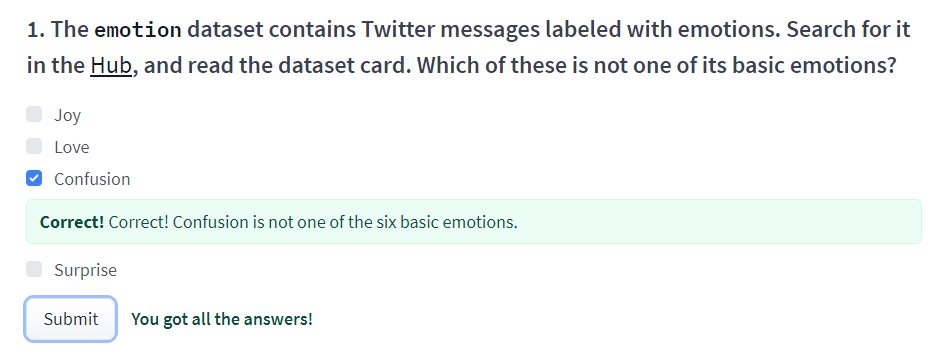

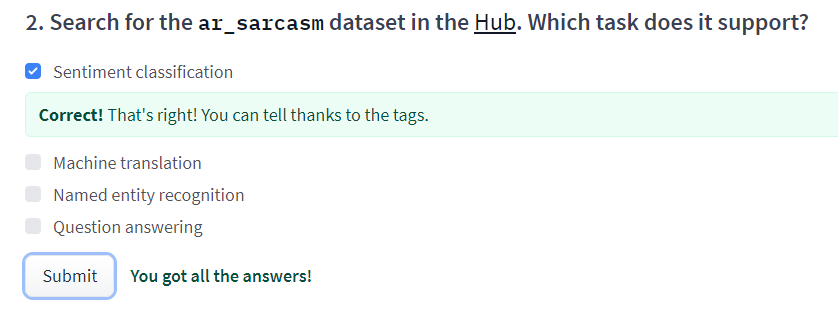

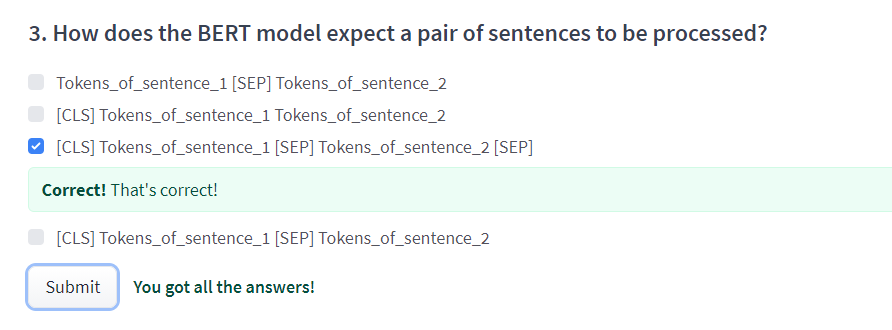

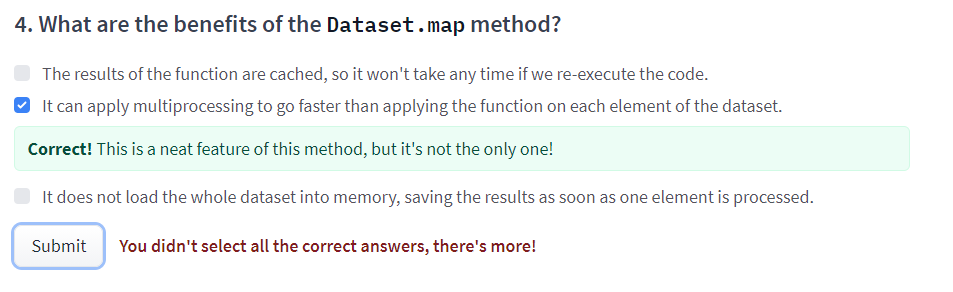

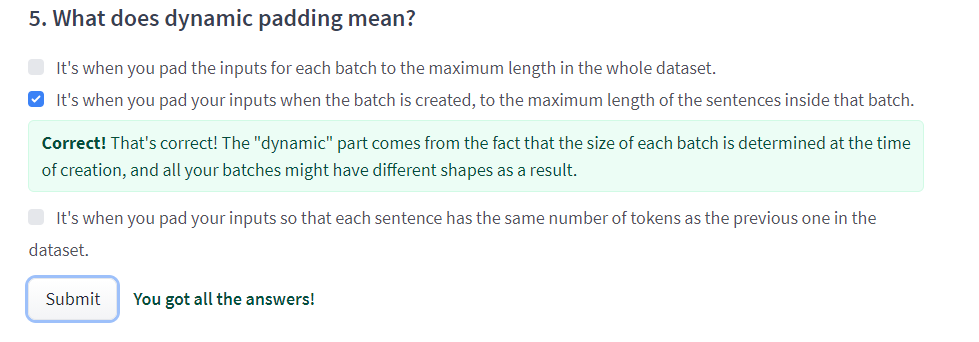

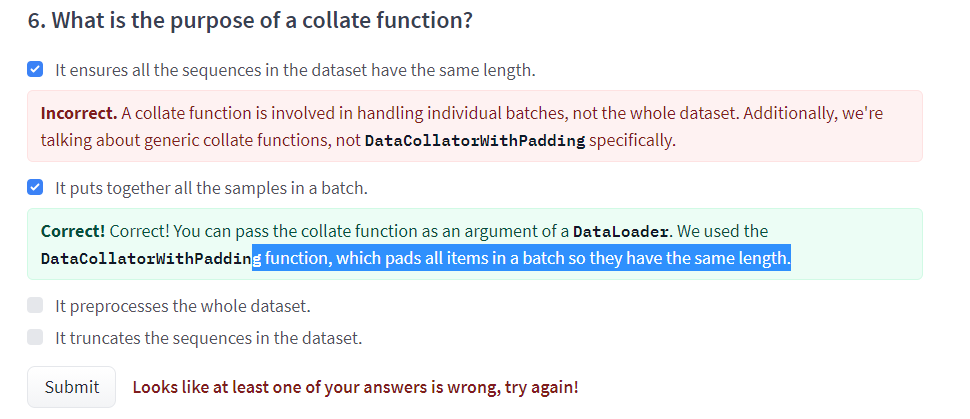

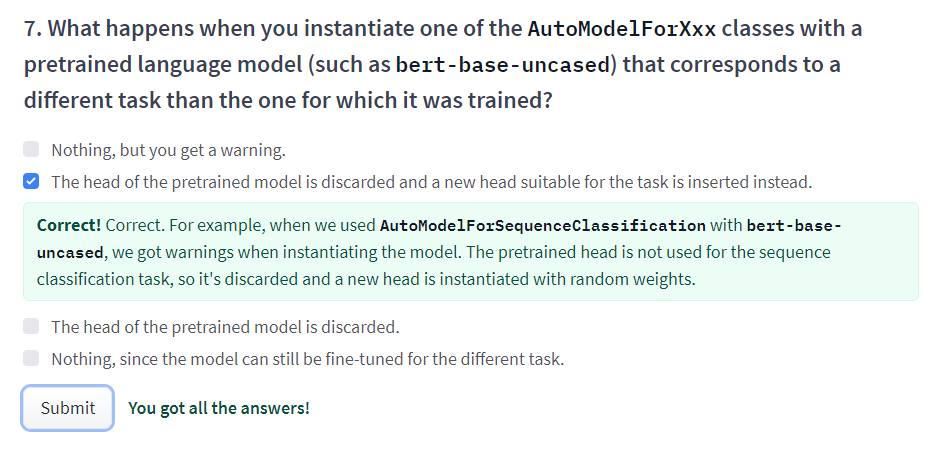

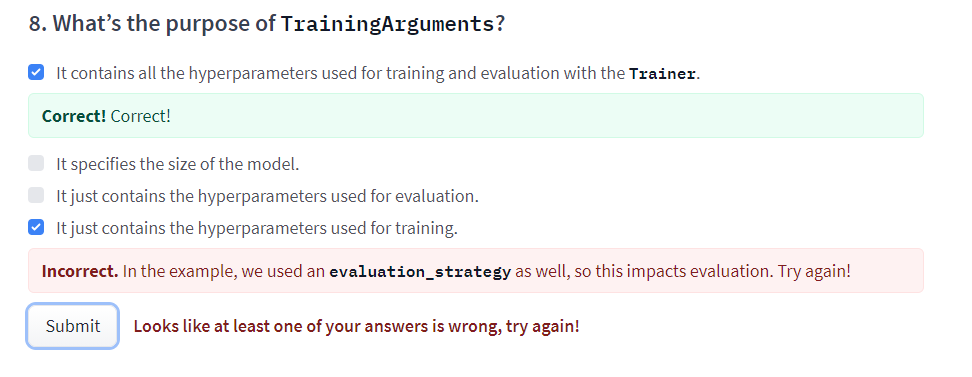

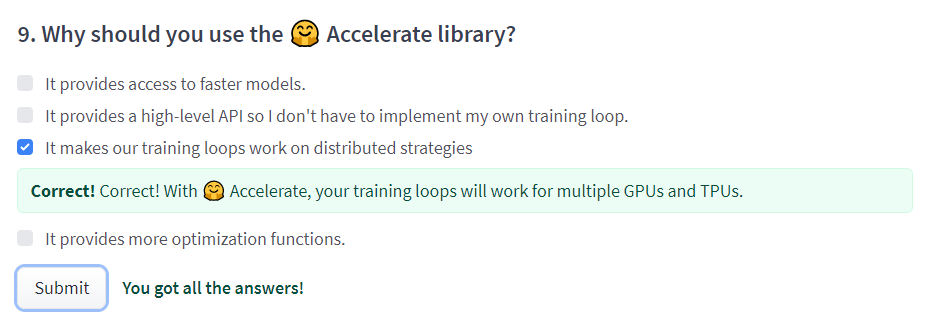